In [1]:
from ceo import constants, StopWatch
import numpy as np
import sys
import matplotlib.pyplot as plt
%matplotlib inline

/home/ubuntu/CEO/python/ceo/zemax


# WFPT model demo with the Probe Zero
This demo shows how to use the Wide Field Phasing Testbed (WFPT) model developed in CEO, using the full Probe Zero.

Developed by: F. Quiros-Pacheco (GMTO)

Last update: 23/03/2022

In [2]:
from ceo import wfpt_simul, wfpt_visulib

## Initialize WFPT model
The WFPT package is located in **~/CEO/python/ceo/wfpt/** . There are so far five WFPT classes:
1. **wfpt_testbed**. The WFPT testbed class that enables ray tracing through the WFPT Zemax model imported in CEO.
2. **wfpt_source**. The class that emulates the illumination source. It contains a "rays bundle" object to raytrace through the WFPT model, and a "CEO Source" object to enable WF propagation from the exit pupil of the WFPT testbed to the WFS. Currently only on-axis propagation possible.
3. **wfpt_sh48**. A wrapper class for the "CEO ShackHartmann" class that implements the SH48 model.
4. **wfpt_dfs**. A wrapper class for the "CEO DispersedFringeSensor" class that implements the DFS model.
5. **wfpt_simul**. A system (container) class that puts together all the above components to perform a full propagation (from source to probe zero signals).

In [3]:
M2_baffle_diam=3.6  # size of M2 baffle
project_truss_onaxis=True # simulate truss shadows over central segment

wfpt = wfpt_simul(M2_baffle_diam=M2_baffle_diam, project_truss_onaxis=project_truss_onaxis)

SH48 pixel scale: 0.421 arcsec


## Propagate a flat wavefront and do calibrations
Activate the keyword **keep_rays_for_plot** if you want to show a ray diagram. Otherwise, set it to *False* to speed up the ray tracing.

In [4]:
keep_rays_for_plot = True

The **calibrate_sensors** method calibrates the reference measurement vectors for both SH and DFS

In [5]:
%%time
wfpt.calibrate_sensors(keep_rays_for_plot=keep_rays_for_plot)

SH source FWHM: 0.842 arcsec
Total SH valid sub-apertures: 1230
SH48 calibration completed.
DFS calibration completed.
CPU times: user 1.93 s, sys: 1.12 s, total: 3.05 s
Wall time: 3.05 s


### Show the WF at the exit pupil

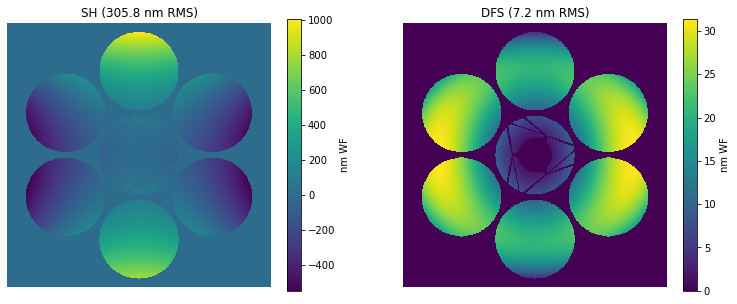

In [6]:
fig, (ax1, ax2) = plt.subplots(ncols=2)
fig.set_size_inches((13,5))
wfpt.show_wavefront(path='SH', subtract_ref_wf=False, fig=fig, ax=ax1)
wfpt.show_wavefront(path='DFS', subtract_ref_wf=False, fig=fig, ax=ax2)

### Show the rays diagram

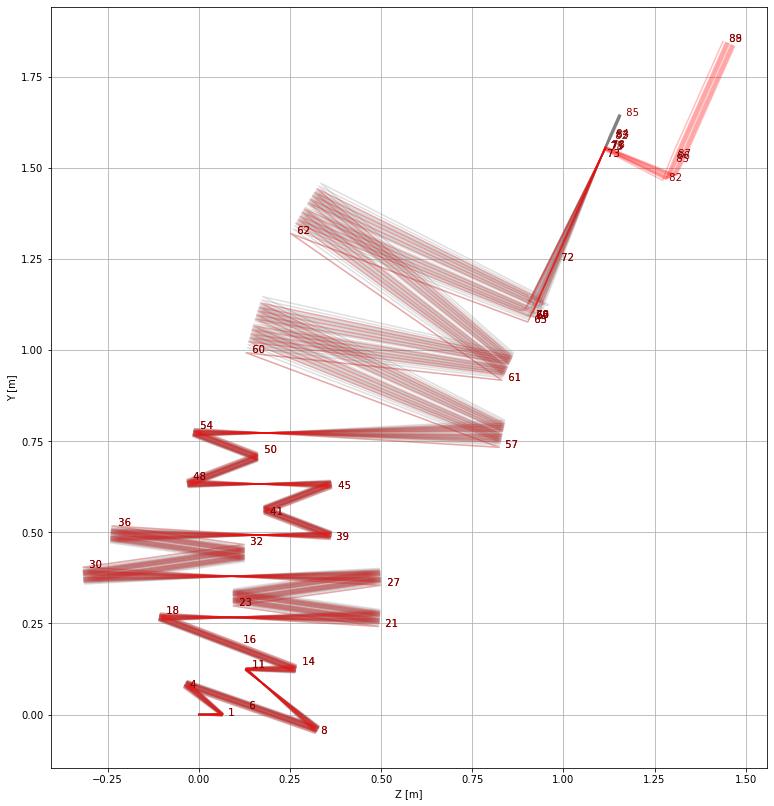

In [7]:
if keep_rays_for_plot == True:
    fig, ax = plt.subplots(figsize=(16,14))
    wfpt.show_rays(path='SH', fig=fig, ax=ax)
    wfpt.show_rays(path='DFS', fig=fig, ax=ax, rays_color='red')

### Show SH calibrations

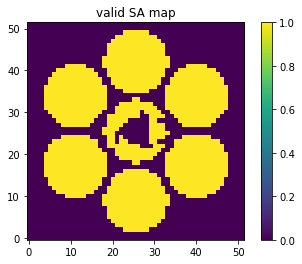

In [8]:
plt.imshow(wfpt.shs.valid_lenslet_mask, origin='lower', interpolation='None')
plt.colorbar();
plt.title('valid SA map');

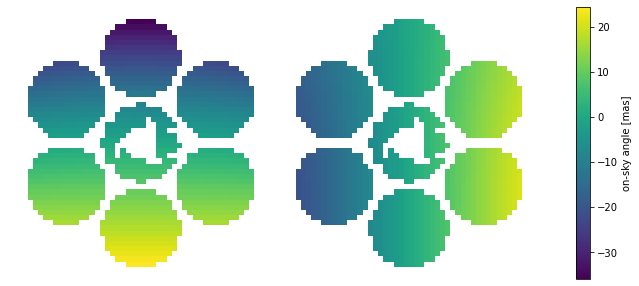

In [9]:
#-- Actual calibrated reference slopes 
#-- units: raw centroid (distance from bottom left corner of sub-aperture) in pixels

CENTER_OF_SUBAP = (wfpt.shs.N_PX_SUBAP-1)/2
sh_ref = (np.squeeze(wfpt.shs.valid_reference_slopes.host()) - CENTER_OF_SUBAP)*wfpt.shs.pixel_scale

sxref2d, syref2d = wfpt.shs.slopes2d(sh_ref)
wfpt_visulib.show_SH_slopes(sxref2d*constants.RAD2MAS, syref2d*constants.RAD2MAS, clb_label='on-sky angle [mas]')

### Show DFS calibrations

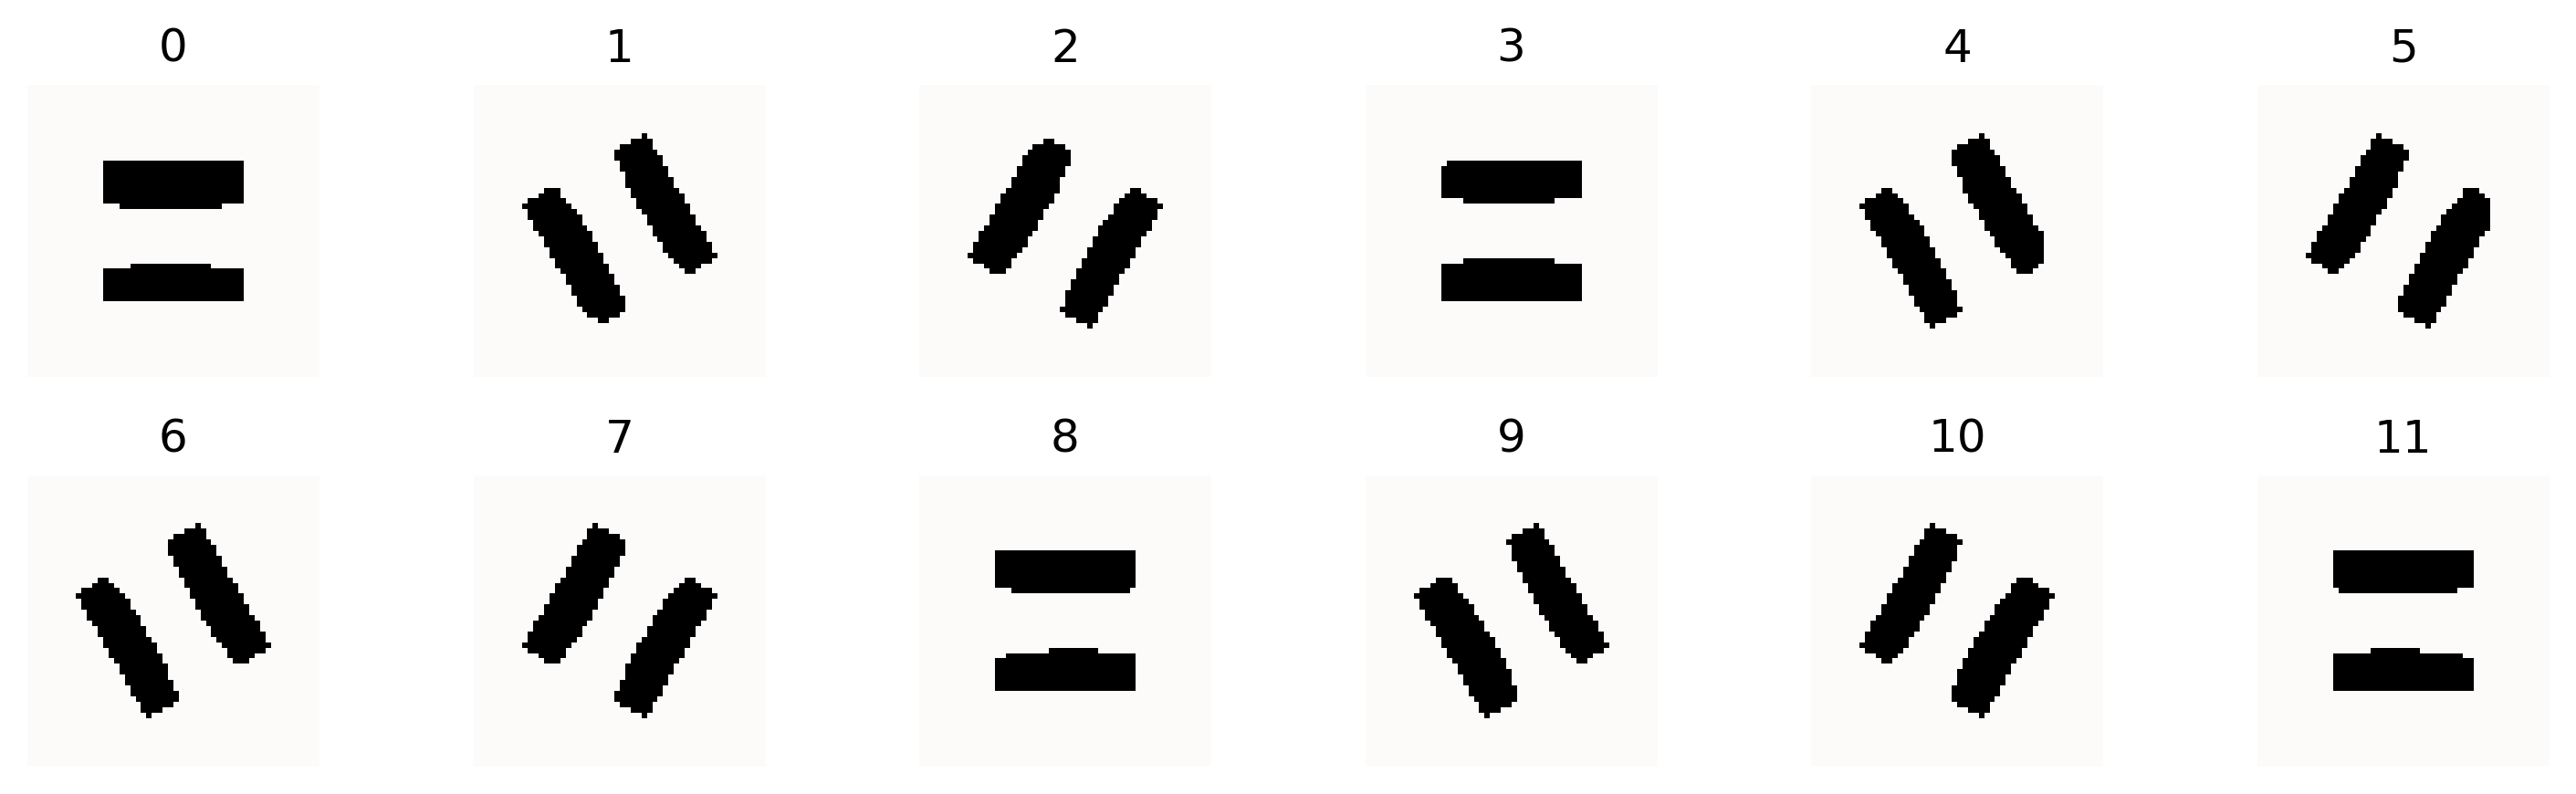

In [10]:
#-- Subaperture masks
dfs_SA_masks = wfpt.dfs.get_data_cube('pupil_masks')
wfpt_visulib.show_DFS_data(dfs_SA_masks)

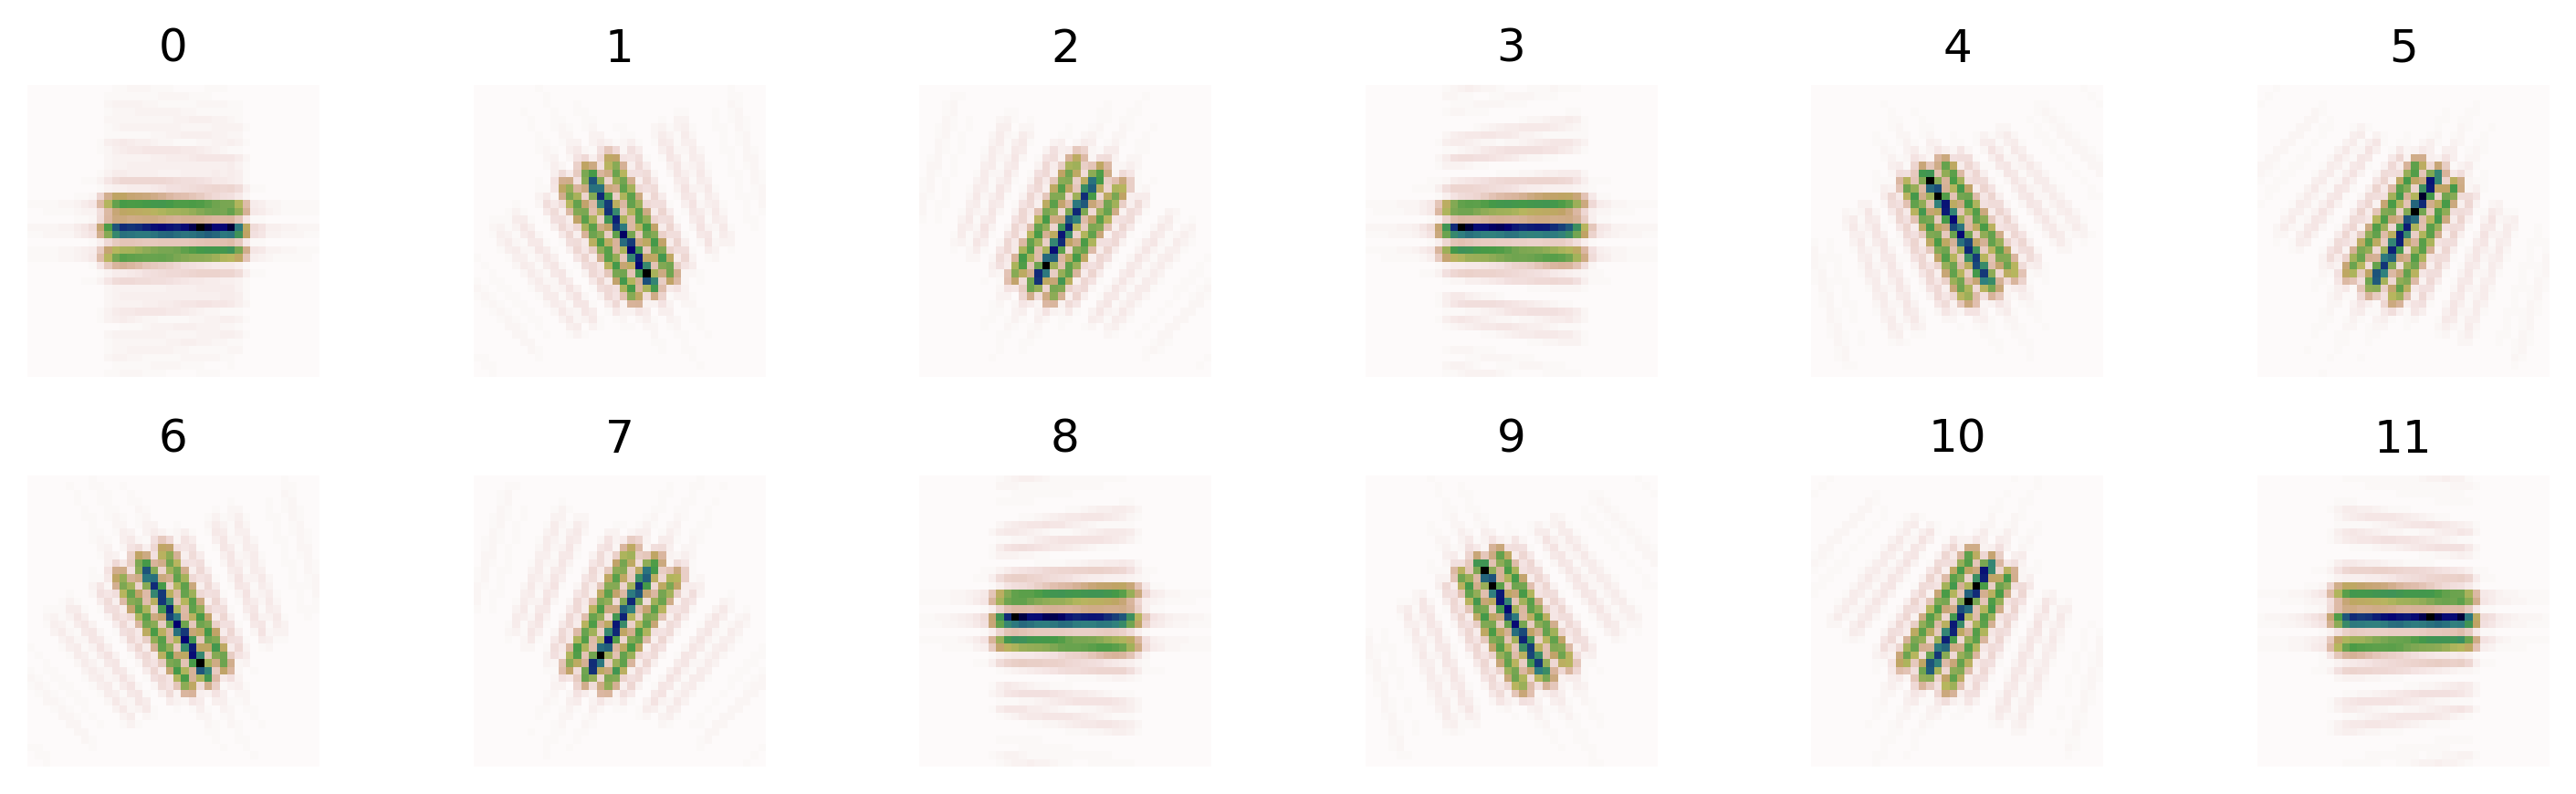

In [11]:
fringes_ref = wfpt.dfs.get_data_cube('camera')
wfpt_visulib.show_DFS_data(fringes_ref)

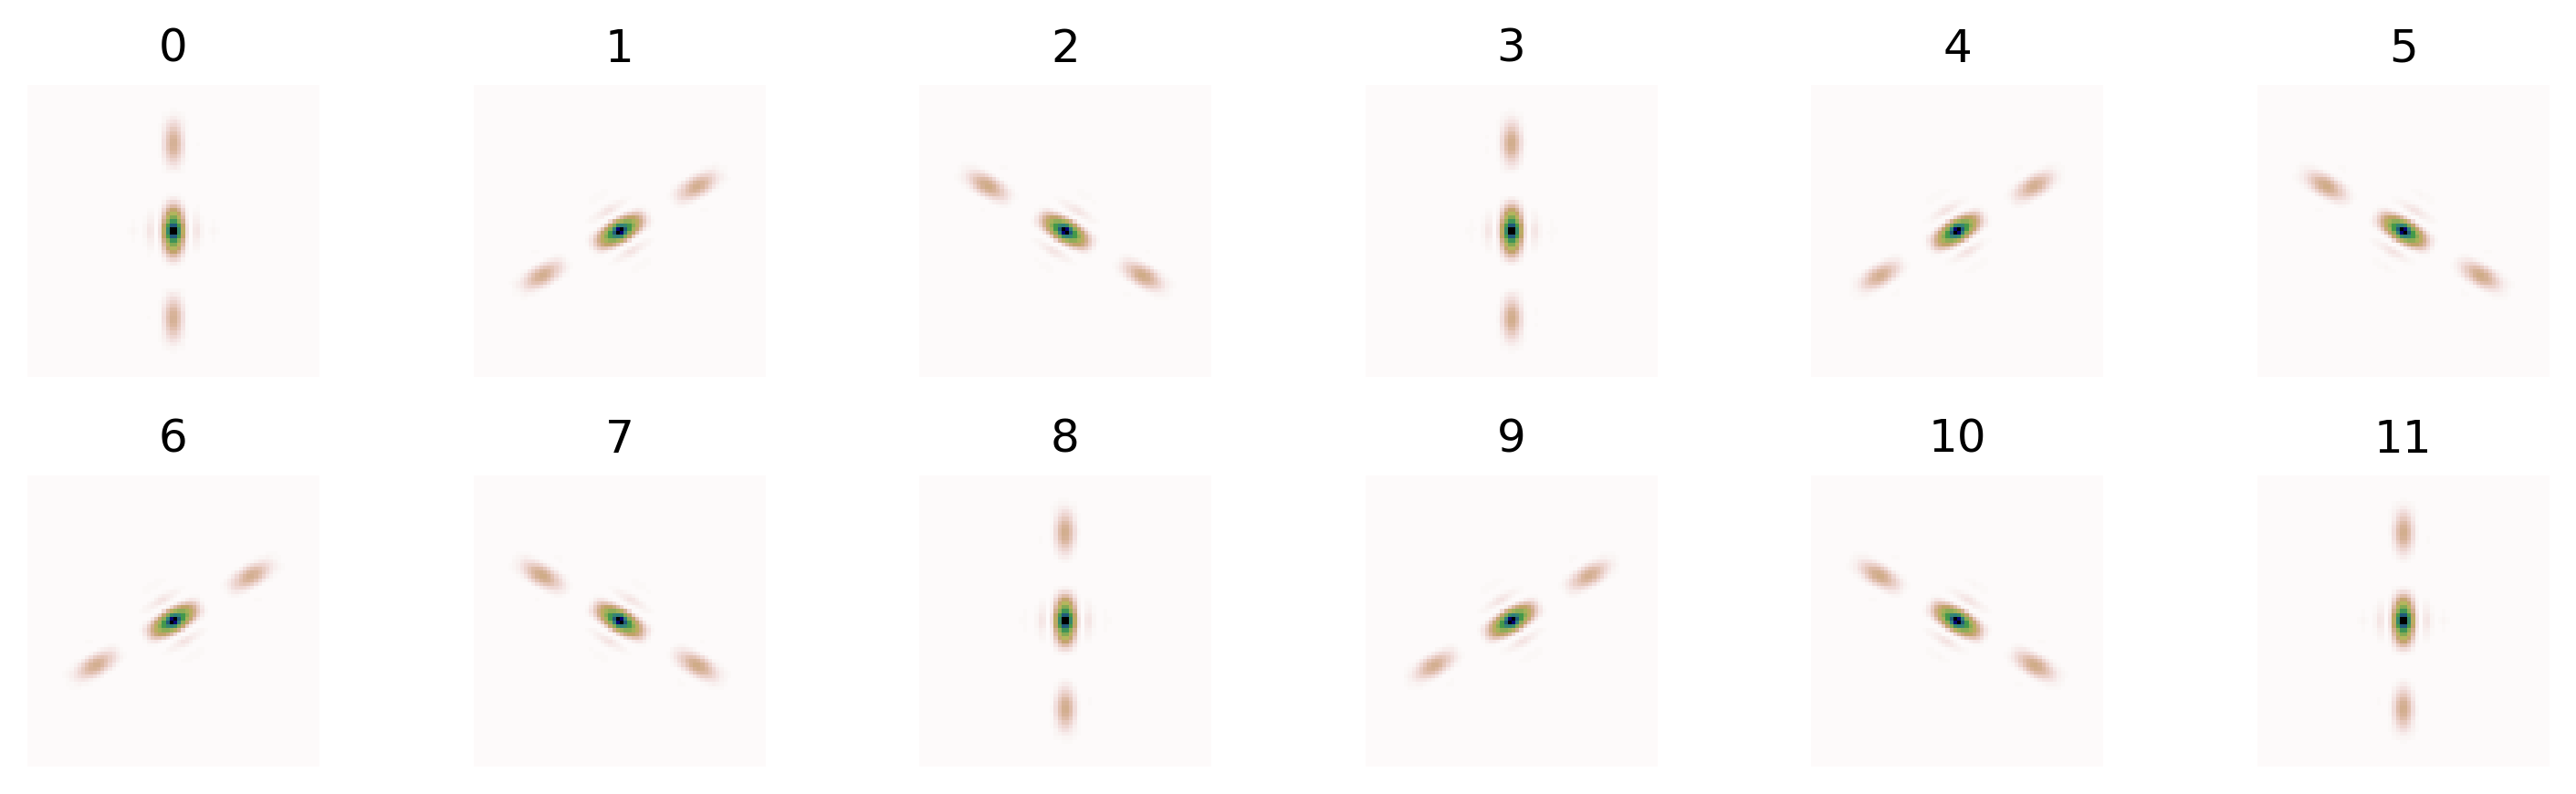

In [12]:
wfpt.dfs.fft()
fftlet_ref = wfpt.dfs.get_data_cube('fftlet')
wfpt_visulib.show_DFS_data(fftlet_ref)

## Test 1: Apply commands to Active Mirrors, propagate wavefront, and check signals
A state vector is defined containing the following degrees of freedom:
1. **M1_PTT**: 
    1. *segment piston*    (7)
    2. *segment tip-tilt*  (7x2)
2. **M2_PTT:** idem
3. **M1_DM:** 
    1. *actuators*      (292)
4. **M2_DM:** idem

In [13]:
print(wfpt.state)

{'M1_PTT': {'segment piston': array([-0., -0., -0., -0., -0., -0., -0.]), 'segment tip-tilt': array([[-0., -0.],
       [-0., -0.],
       [-0., -0.],
       [-0., -0.],
       [-0., -0.],
       [-0., -0.],
       [-0., -0.]])}, 'M2_PTT': {'segment piston': array([0., 0., 0., 0., 0., 0., 0.]), 'segment tip-tilt': array([[0., 0.],
       [0., 0.],
       [0., 0.],
       [0., 0.],
       [0., 0.],
       [0., 0.],
       [0., 0.]])}, 'M1_DM': {'actuators': array([-0., -0., -0., -0., -0., -0., -0., -0., -0., -0., -0., -0., -0.,
       -0., -0., -0., -0., -0., -0., -0., -0., -0., -0., -0., -0., -0.,
       -0., -0., -0., -0., -0., -0., -0., -0., -0., -0., -0., -0., -0.,
       -0., -0., -0., -0., -0., -0., -0., -0., -0., -0., -0., -0., -0.,
       -0., -0., -0., -0., -0., -0., -0., -0., -0., -0., -0., -0., -0.,
       -0., -0., -0., -0., -0., -0., -0., -0., -0., -0., -0., -0., -0.,
       -0., -0., -0., -0., -0., -0., -0., -0., -0., -0., -0., -0., -0.,
       -0., -0., -0., -0., -0., -0.

To apply a command you should:
1. Extract a copy of the state vector (can be done only once);
2. Modify the copy of the state vector as desired;
3. Update the WFPT model with the desired state vector.

In [14]:
wfpt.reset()

# Extract copy of state vector
state = wfpt.state

# Modify the state vector as desired
state['M1_DM']['actuators'][150] = -1
#state['M2_DM']['actuators'][150] = 1
#state['M2_PTT']['segment tip-tilt'][:,0] = 1e-5
#state['M2_PTT']['segment piston'][3] = 500e-9

# Update the WFPT model with the desired state vector
wfpt.update(state)

Propagate WF through testbed

CPU times: user 1.12 s, sys: 592 ms, total: 1.72 s
Wall time: 1.71 s


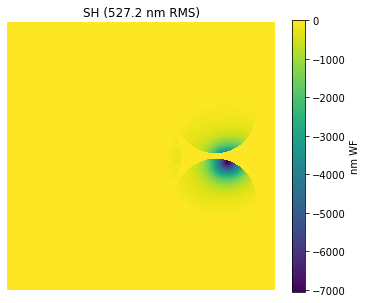

In [15]:
%%time
wfpt.reset_sources()
wfpt.reset_sensors()
wfpt.propagate()
wfpt.show_wavefront(path='SH')#, title='M1 seg piston')

### SH measurements

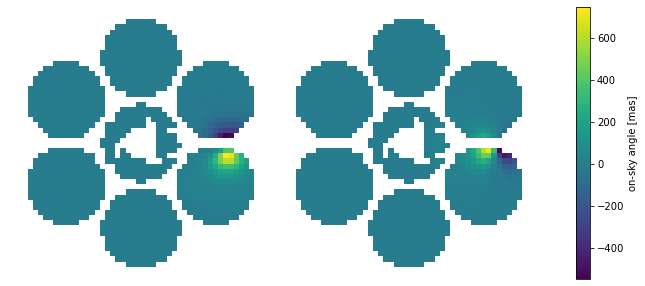

In [16]:
wfpt.shs.process()

sx2d, sy2d = wfpt.shs.slopes2d()
wfpt_visulib.show_SH_slopes(sx2d*constants.RAD2MAS, sy2d*constants.RAD2MAS, clb_label='on-sky angle [mas]')

SH detector frame:

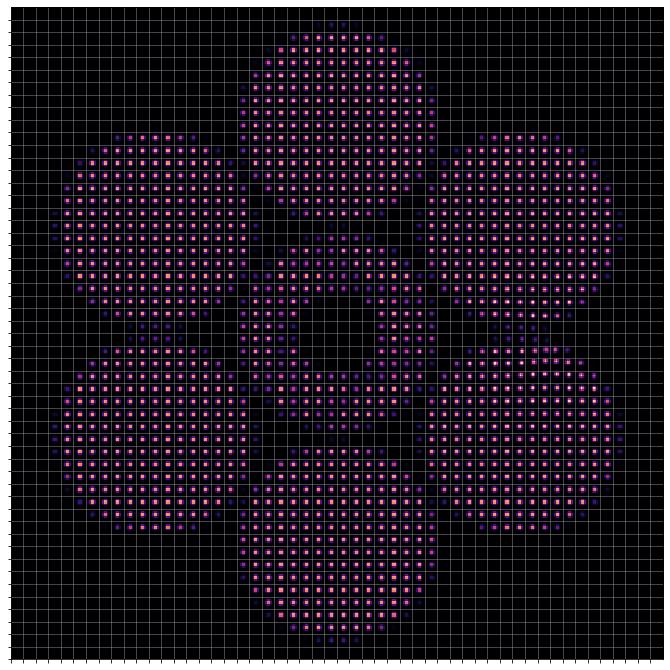

In [17]:
fig,ax = plt.subplots(figsize=(16,12))
ax.imshow(wfpt.shs.camera.frame.host(),cmap='magma', origin='lower', interpolation='None')
ax.set_xticks(np.arange(0,8*wfpt.shs.N_SIDE_LENSLET,8)-0.5)
ax.set_yticks(np.arange(0,8*wfpt.shs.N_SIDE_LENSLET,8)-0.5)
ax.set_xticklabels([])
ax.set_yticklabels([])
ax.grid(alpha=0.5)

SH signal vector

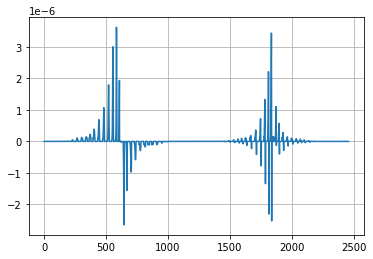

In [18]:
plt.plot(wfpt.shs.get_measurement())
plt.grid()

### DFS measurements

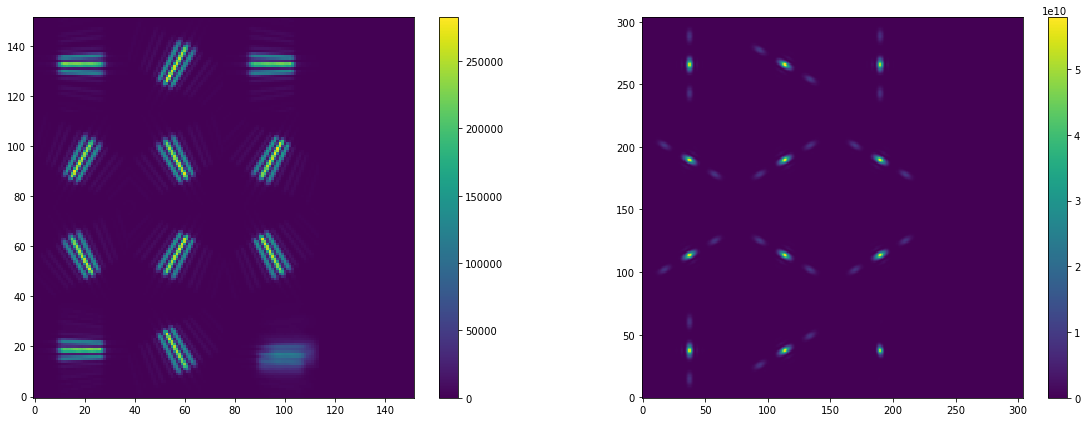

In [19]:
wfpt.dfs.fft()
wfpt.dfs.process()

fig, (ax1,ax2) = plt.subplots(ncols=2)
fig.set_size_inches((20,7))
h1 = ax1.imshow(wfpt.dfs.camera.frame.host(),interpolation='None',origin='lower')
fig.colorbar(h1,ax=ax1)
h2 = ax2.imshow(wfpt.dfs.fftlet.host(),interpolation='None',origin='lower')
fig.colorbar(h2,ax=ax2)

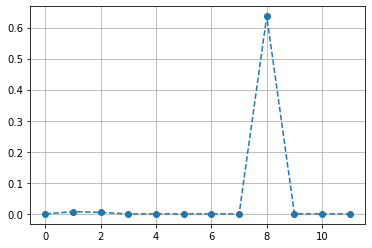

In [20]:
plt.plot(wfpt.dfs.get_measurement(), 'o--')
plt.grid()

## Interaction Matrix Calibration

In [21]:
%%time
D = wfpt.interaction_matrix(mirror='M1', modes='zonal') 

___ M1 ___ (actuators)
0 1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24 25 26 27 28 29 30 31 32 33 34 35 36 37 38 39 40 41 42 43 44 45 46 47 48 49 50 51 52 53 54 55 56 57 58 59 60 61 62 63 64 65 66 67 68 69 70 71 72 73 74 75 76 77 78 79 80 81 82 83 84 85 86 87 88 89 90 91 92 93 94 95 96 97 98 99 100 101 102 103 104 105 106 107 108 109 110 111 112 113 114 115 116 117 118 119 120 121 122 123 124 125 126 127 128 129 130 131 132 133 134 135 136 137 138 139 140 141 142 143 144 145 146 147 148 149 150 151 152 153 154 155 156 157 158 159 160 161 162 163 164 165 166 167 168 169 170 171 172 173 174 175 176 177 178 179 180 181 182 183 184 185 186 187 188 189 190 191 192 193 194 195 196 197 198 199 200 201 202 203 204 205 206 207 208 209 210 211 212 213 214 215 216 217 218 219 220 221 222 223 224 225 226 227 228 229 230 231 232 233 234 235 236 237 238 239 240 241 242 243 244 245 246 247 248 249 250 251 252 253 254 255 256 257 258 259 260 261 262 263 264 265 266 267 268 269 270 271

In [22]:
D['M1'].keys()

dict_keys(['sh-dm', 'sh-stt', 'dfs-dm', 'dfs-stt', 'dfs-spp'])

### Show interaction matrices with the DFS

In [23]:
#-- To convert DFS signals in pixels to nanometers of 
#-- differential piston (Surface) between adjacent segments (12 values)
DFSsig2pist = np.diag(1 / np.max(np.abs(D['M1']['dfs-spp']), axis=1))

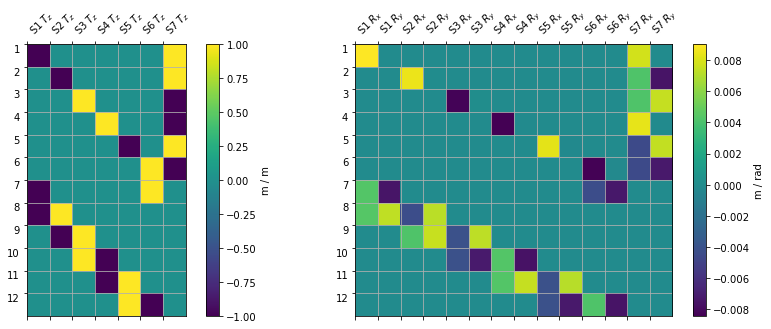

In [24]:
fig2, (ax1,ax2) = plt.subplots(ncols=2)
fig2.set_size_inches(16,5)
fig.dpi = 1200

im1 = ax1.matshow(DFSsig2pist @ D['M1']['dfs-spp'])
ax1.grid()
ax1.set_yticks(np.arange(12)-0.5);
ax1.set_yticklabels(np.arange(1,13).tolist(), va='top')
ax1.set_xticks(np.arange(7)-0.5);
ax1.set_xticklabels(['S1 $T_z$','S2 $T_z$','S3 $T_z$','S4 $T_z$','S5 $T_z$','S6 $T_z$','S7 $T_z$'], 
                    ha='left', fontsize=10, 
                    rotation=45)
clb1 = fig.colorbar(im1, ax=ax1, label='m / m')


im2 = ax2.matshow(DFSsig2pist @ D['M1']['dfs-stt'])
ax2.grid()
ax2.set_yticks(np.arange(12)-0.5);
ax2.set_yticklabels(np.arange(1,13).tolist(), va='top')
ax2.set_xticks(np.arange(14)-0.5);
ax2.set_xticklabels(['S1 $R_x$','S1 $R_y$','S2 $R_x$','S2 $R_y$','S3 $R_x$','S3 $R_y$',
        'S4 $R_x$','S4 $R_y$','S5 $R_x$','S5 $R_y$','S6 $R_x$','S6 $R_y$','S7 $R_x$','S7 $R_y$'],
        ha='left', fontsize=10, rotation=45)
clb2 = fig.colorbar(im2, ax=ax2, label='m / rad')
fig.tight_layout()

Text(0, 0.5, 'DFS subap #')

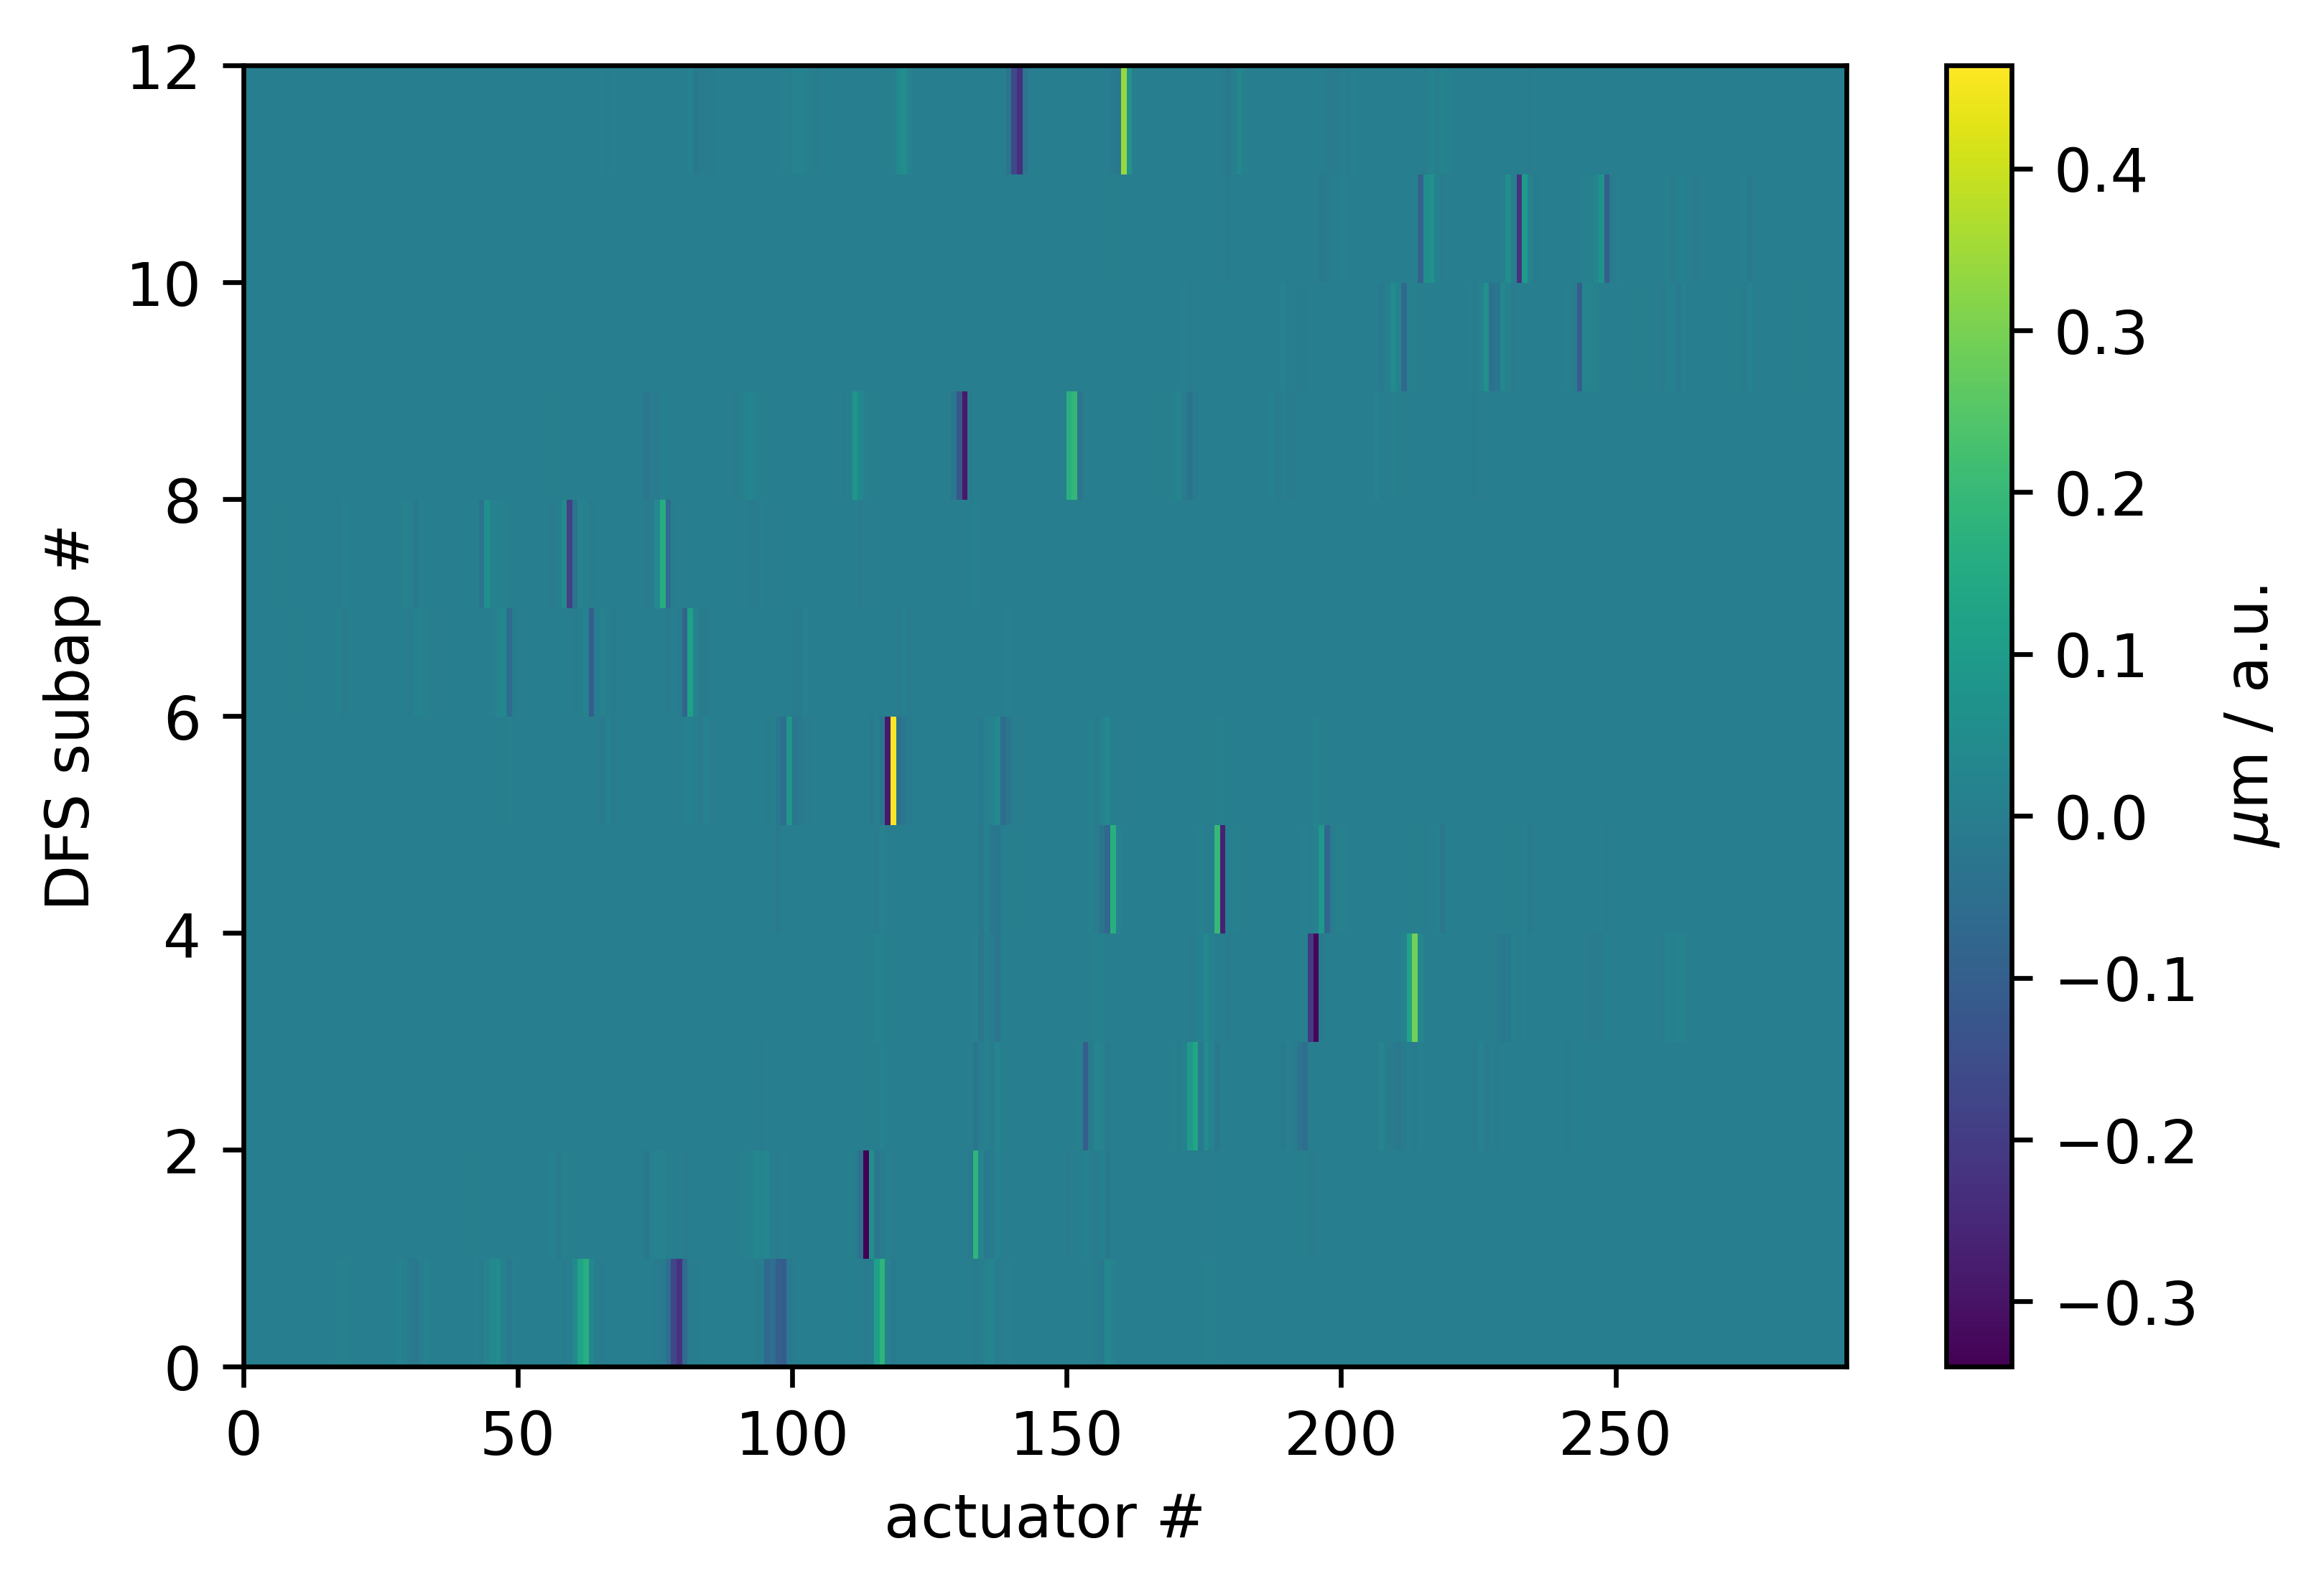

In [140]:
fig, ax3 = plt.subplots()
fig2.set_size_inches(20,15)
fig.dpi = 600

im3 = ax3.pcolor(DFSsig2pist @ D['M1']['dfs-dm']*1e6)
clb3 = fig.colorbar(im3, ax=ax3, label='$\mu$m / a.u.')
ax3.set_xlabel('actuator #')
ax3.set_ylabel('DFS subap #')
#ax3.grid()
#ax3.set_yticks(np.arange(12)-0.5);
#ax3.set_yticklabels(np.arange(1,13).tolist(), va='top')


## Rec Test 1. M1 DM - SH48

### Interaction Matrix

In [31]:
#-- M1_DM-SH matrix
D_M1_ALPAO = D['M1']['sh-dm']

### SVD analysis

M1 DM - SH48 IM:
(2460, 292)
conditioning number:
532.0773247990245


Text(0.5, 1.0, 'M1 DM - SH48 (on-axis)')

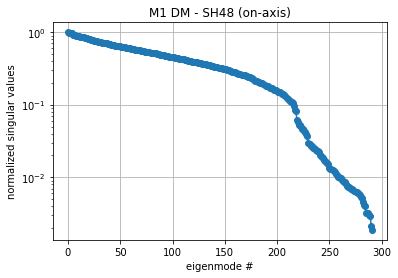

In [32]:
print('M1 DM - SH48 IM:')
print(D_M1_ALPAO.shape)
print("conditioning number:")
print(np.linalg.cond(D_M1_ALPAO))

UU1, ss1, VVT1 = np.linalg.svd(D_M1_ALPAO, full_matrices=False)
plt.semilogy(ss1/np.max(ss1), 'o-')
plt.grid()
plt.ylabel('normalized singular values')
plt.xlabel('eigenmode #')
plt.title('M1 DM - SH48 (on-axis)')

#### Show the shape of a particular eigenmode just for fun

command median value: -0.0026


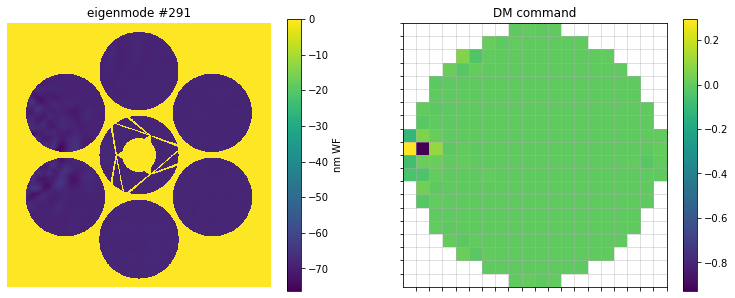

In [33]:
this_eigen = 290
eigenmodevec = np.copy(VVT1[this_eigen,:])

wfpt.reset()
state = wfpt.state
state['M1_DM']['actuators'][:] = eigenmodevec
wfpt.update(state)
wfpt.shs_path.propagate(wfpt.shs_src)

fig, (ax1,ax2) = plt.subplots(ncols=2)
fig.set_size_inches((13,5))
wfpt.show_wavefront(path='SH', fig=fig, ax=ax1)
wfpt_visulib.show_dm292(eigenmodevec, fig=fig, ax=ax2)
ax1.set_title('eigenmode #%d'%(this_eigen+1))
ax2.set_title('DM command')

print("command median value: %0.4f"%(np.median(eigenmodevec)))

In [34]:
#--- Find which actuators exhibit large peak values:
actidx = np.argwhere(np.abs(eigenmodevec) > 0.3)
actidx, eigenmodevec[actidx]

(array([[144]]), array([[-0.9277465]]))

### Compute reconstructor

In [35]:
R_M1_ALPAO = np.linalg.pinv(D_M1_ALPAO)

### Test reconstructor

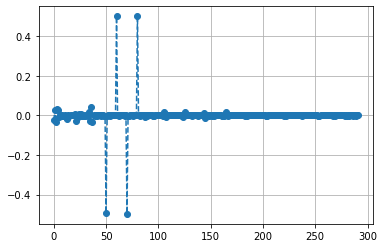

In [37]:
wfpt.reset()

state = wfpt.state
state['M1_DM']['actuators'][80] = 0.5
state['M1_DM']['actuators'][70] = -0.5
state['M1_DM']['actuators'][60] = 0.5
state['M1_DM']['actuators'][50] = -0.5
wfpt.update(state)


wfpt.propagate()
wfpt.shs.process()
sh_meas = wfpt.shs.get_measurement()

dm1_comm = R_M1_ALPAO @ sh_meas

#plt.imshow(WFin-opd0, origin='lower', interpolation='None')
#plt.colorbar()
plt.plot(dm1_comm, 'o--')
plt.grid()

### Perform a closed-loop test

#### Introduce a scramble

In [38]:
from numpy.random import default_rng
rng = default_rng(seed=1454)

Text(0.5, 1.0, 'DM command')

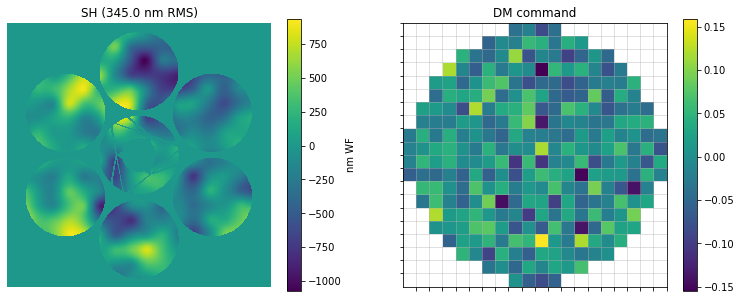

In [39]:
# Scramble:
wfpt.reset()
state0 = wfpt.state
#state0['M1_PTT']['segment tip-tilt'][:] = rng.standard_normal(size=(7,2)) * 1e-4
#state0['M1_PTT']['segment tip-tilt'][0,0] = 1e-4
#state0['M1_DM']['actuators'][181] = 0.5
state0['M1_DM']['actuators'][:] = rng.standard_normal(size=wfpt.shs_path.M1_DM.modes.n_mode)*0.05
wfpt.update(state0)

# Visualize the scramble
wfpt.shs_src.reset()
wfpt.shs_path.propagate(wfpt.shs_src)

fig, (ax1,ax2) = plt.subplots(ncols=2)
fig.set_size_inches((13,5))
wfpt.show_wavefront(path='SH', fig=fig, ax=ax1)
wfpt_visulib.show_dm292(state0['M1_DM']['actuators'], fig=fig, ax=ax2)
ax2.set_title('DM command')

#### Close the loop

In [40]:
totSimulIter = 30
gain = 0.2
tid = StopWatch()

M1_DM_comm_buffer = np.zeros(wfpt.shs_path.M1_DM.modes.n_mode)
wfe_iter = np.zeros(totSimulIter)

In [41]:
# Get 
wfpt.reset()
state = wfpt.state

# Load initial scramble
wfpt.update(state0)

for jj in range(totSimulIter):
    tid.tic()
    wfpt.reset_sources()
    wfpt.reset_sensors()
    wfpt.propagate()
    wfe_iter[jj] = wfpt.shs_src.phaseRms()
    
    #--- WFS measurements and command
    wfpt.shs.process()
    measvec = wfpt.shs.get_measurement()
    M1_DM_delta_comm = R_M1_ALPAO @ measvec
    M1_DM_comm_buffer += gain * M1_DM_delta_comm
    
    #--- Update state vector
    state['M1_DM']['actuators'] = -M1_DM_comm_buffer
    wfpt.update(state0+state)

    tid.toc()
    sys.stdout.write("\r iter: %d/%d, ET: %.2f, WFE [nm WF RMS] on-axis: %0.1f"%(jj, totSimulIter, tid.elapsedTime, wfe_iter[jj]*1e9))
    sys.stdout.flush()   


 iter: 29/30, ET: 1668.66, WFE [nm WF RMS] on-axis: 0.51

Text(0, 0.5, 'WFE [nm RMS]')

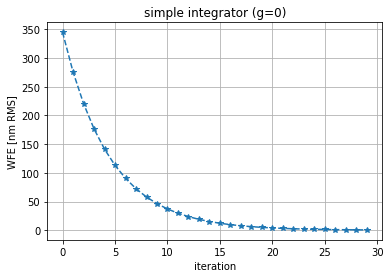

In [42]:
plt.plot(wfe_iter*1e9, '*--')
plt.grid()
plt.xlabel('iteration')
plt.title('simple integrator (g=%0.1f)'%gain)
plt.ylabel('WFE [nm RMS]')

Text(0.5, 1.0, 'DM command')

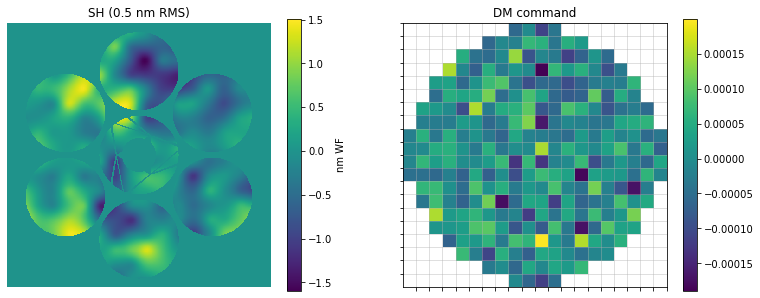

In [43]:
fig, (ax1,ax2) = plt.subplots(ncols=2)
fig.set_size_inches((13,5))
wfpt.show_wavefront(path='SH', fig=fig, ax=ax1)
wfpt_visulib.show_dm292(wfpt.state['M1_DM']['actuators'], fig=fig, ax=ax2)
ax2.set_title('DM command')

## Rec Test 2. M1 PTT - SH48
Controlling only segment tip-tilt

### Interaction Matrix

In [44]:
#-- M1_DM-SH matrix
D_PTT = D['M1']['sh-stt']

### SVD analysis

M1 PTT - SH48 IM:
(2460, 14)
conditioning number:
1.2267130717029324


Text(0.5, 1.0, 'M1 sTT - SH48 (on-axis)')

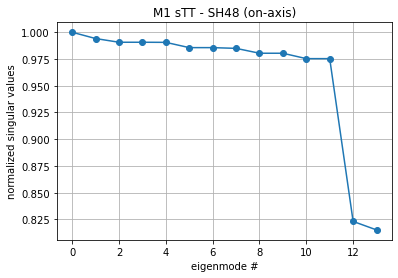

In [45]:
print('M1 PTT - SH48 IM:')
print(D_PTT.shape)
print("conditioning number:")
print(np.linalg.cond(D_PTT))

UU1, ss1, VVT1 = np.linalg.svd(D_PTT, full_matrices=False)
plt.plot(ss1/np.max(ss1), 'o-')
plt.grid()
plt.ylabel('normalized singular values')
plt.xlabel('eigenmode #')
plt.title('M1 sTT - SH48 (on-axis)')

#### Show the shape of a particular eigenmode just for fun

Text(0.5, 1.0, 'eigenmode #13')

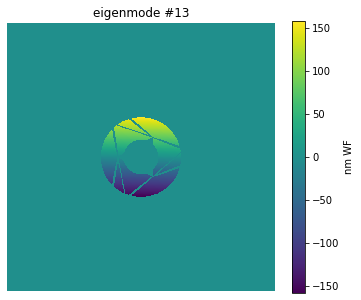

In [46]:
this_eigen = 12
eigenmodevec = np.copy(VVT1[this_eigen,:]) * 1e-5

wfpt.reset()
state = wfpt.state
state['M1_PTT']['segment tip-tilt'][:] = eigenmodevec.reshape((7,2))
wfpt.update(state)
wfpt.shs_path.propagate(wfpt.shs_src)

fig, ax1 = plt.subplots()
fig.set_size_inches((6,5))
wfpt.show_wavefront(path='SH', fig=fig, ax=ax1)
ax1.set_title('eigenmode #%d'%(this_eigen+1))

### Compute reconstructor

In [47]:
R_PTT = np.linalg.pinv(D_PTT)

### Test reconstructor

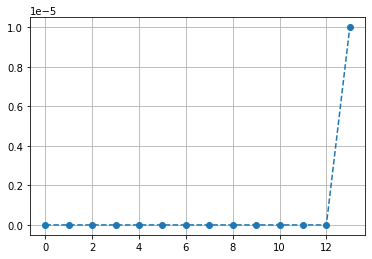

In [48]:
wfpt.reset()

state = wfpt.state
state['M1_PTT']['segment tip-tilt'][6,1] = 1e-5
wfpt.update(state)
wfpt.shs_path.propagate(wfpt.shs_src)
wfpt.shs.propagate(wfpt.shs_src)
wfpt.shs.process()
sh_meas = wfpt.shs.get_measurement()

ptt_comm = R_PTT @ sh_meas

#plt.imshow(WFin-opd0, origin='lower', interpolation='None')
#plt.colorbar()
plt.plot(ptt_comm, 'o--')
plt.grid()

### Perform a closed-loop test

#### Introduce a scramble

In [49]:
from numpy.random import default_rng
rng = default_rng(seed=1454)

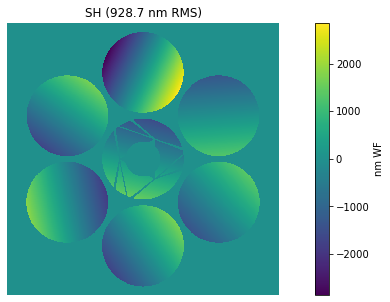

In [50]:
# Scramble:
wfpt.reset()
state0 = wfpt.state
state0['M1_PTT']['segment tip-tilt'][:] = rng.standard_normal(size=(7,2)) * 1e-4
#state0['M1_PTT']['segment tip-tilt'][0,0] = 1e-4
#state0['M1_DM']['actuators'][181] = 0.5
#state0['M1_DM']['actuators'][:] = rng.standard_normal(size=wfpt.shs_path.M1_DM.modes.n_mode)*0.05
wfpt.update(state0)

# Visualize the scramble
wfpt.shs_src.reset()
wfpt.shs_path.propagate(wfpt.shs_src)

fig, ax1 = plt.subplots()
fig.set_size_inches((13,5))
wfpt.show_wavefront(path='SH', fig=fig, ax=ax1)

#### Close the loop

In [51]:
totSimulIter = 30
gain = 0.2
tid = StopWatch()

M1_PTT_comm_buffer = np.zeros(14)
wfe_iter = np.zeros(totSimulIter)

In [52]:
# Get 
wfpt.reset()
state = wfpt.state

# Load initial scramble
wfpt.update(state0)

for jj in range(totSimulIter):
    tid.tic()
    wfpt.reset_sources()
    wfpt.reset_sensors()
    wfpt.propagate()
    wfe_iter[jj] = wfpt.shs_src.phaseRms()
    
    #--- WFS measurements and command
    wfpt.shs.process()
    measvec = wfpt.shs.get_measurement()
    M1_PTT_delta_comm = R_PTT @ measvec
    M1_PTT_comm_buffer += gain * M1_PTT_delta_comm
    
    #--- Update state vector
    state['M1_PTT']['segment tip-tilt'][:] = -M1_PTT_comm_buffer.reshape((7,2))
    wfpt.update(state0+state)

    tid.toc()
    sys.stdout.write("\r iter: %d/%d, ET: %.2f, WFE [nm WF RMS] on-axis: %0.1f"%(jj, totSimulIter, tid.elapsedTime, wfe_iter[jj]*1e9))
    sys.stdout.flush()   


 iter: 29/30, ET: 1645.85, WFE [nm WF RMS] on-axis: 1.47

Text(0, 0.5, 'WFE [nm RMS]')

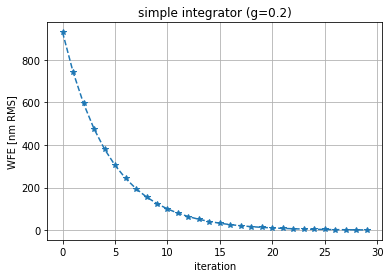

In [53]:
plt.plot(wfe_iter*1e9, '*--')
plt.grid()
plt.xlabel('iteration')
plt.title('simple integrator (g=%0.1f)'%gain)
plt.ylabel('WFE [nm RMS]')

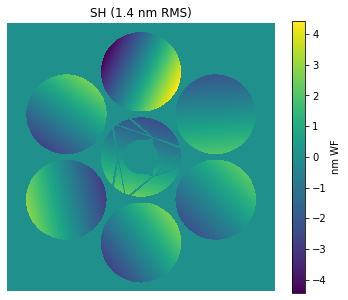

In [54]:
wfpt.show_wavefront(path='SH')

## Rec Test 3. M1 PTT - DFS
Controlling only segment piston

### Interaction Matrix

In [55]:
#-- M1_DM-SH matrix
D_PTT = D['M1']['dfs-spp']

### SVD analysis

M1 PTT - DFS IM:
(12, 7)
conditioning number:
651468.7331813719


Text(0.5, 1.0, 'M1 SPP - DFS (on-axis)')

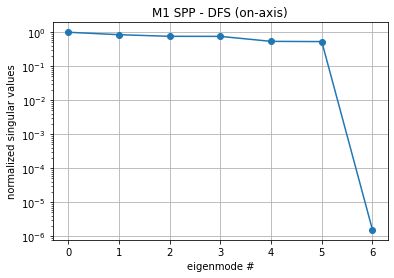

In [56]:
print('M1 PTT - DFS IM:')
print(D_PTT.shape)
print("conditioning number:")
print(np.linalg.cond(D_PTT))

UU1, ss1, VVT1 = np.linalg.svd(D_PTT, full_matrices=False)
plt.semilogy(ss1/np.max(ss1), 'o-')
plt.grid()
plt.ylabel('normalized singular values')
plt.xlabel('eigenmode #')
plt.title('M1 SPP - DFS (on-axis)')

#### Show the shape of a particular eigenmode just for fun

Text(0.5, 1.0, 'eigenmode #7')

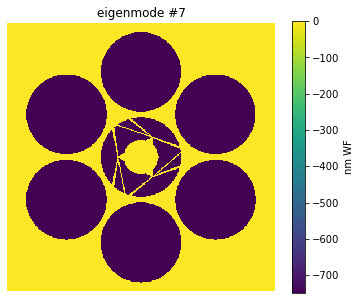

In [57]:
this_eigen = 6
eigenmodevec = np.copy(VVT1[this_eigen,:]) * 1e-6

wfpt.reset()
state = wfpt.state
state['M1_PTT']['segment piston'][:] = eigenmodevec
wfpt.update(state)
wfpt.dfs_path.propagate(wfpt.dfs_src)

fig, ax1 = plt.subplots()
fig.set_size_inches((6,5))
wfpt.show_wavefront(path='DFS', fig=fig, ax=ax1)
ax1.set_title('eigenmode #%d'%(this_eigen+1))

### Compute reconstructor
The reconstructors below provide the same performance

In [58]:
noise = np.ones(12)
cnninv = np.diag(1./noise)
Wp = 1e15*np.ones((7,7))
R_PTT = np.linalg.solve(D_PTT.T@cnninv@D_PTT+Wp,D_PTT.T@cnninv)

### Test reconstructor

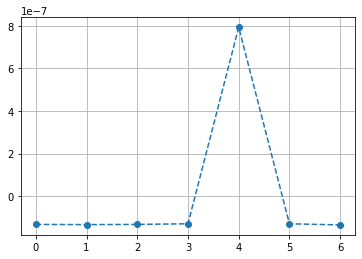

In [59]:
wfpt.reset()

state = wfpt.state
state['M1_PTT']['segment piston'][4] = 1e-6
wfpt.update(state)
wfpt.dfs_path.propagate(wfpt.dfs_src)
wfpt.dfs.propagate(wfpt.dfs_src)
wfpt.dfs.fft()
wfpt.dfs.process()
dfs_meas = wfpt.dfs.get_measurement()

ptt_comm = R_PTT @ dfs_meas

#plt.imshow(WFin-opd0, origin='lower', interpolation='None')
#plt.colorbar()
plt.plot(ptt_comm, 'o--')
plt.grid()

### Perform a closed-loop test

#### Introduce a scramble

In [60]:
from numpy.random import default_rng
rng = default_rng(seed=1454)

Global piston [nm]: -841.5
Segment piston [nm]: [-1517.2 -3236.4  -724.7 -1486.2   505.4  1691.2 -1239.5]


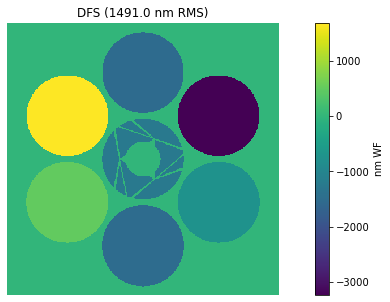

In [61]:
# Scramble:
wfpt.reset()
state0 = wfpt.state
state0['M1_PTT']['segment piston'][:] = rng.standard_normal(size=7) * 1e-6
#state0['M1_PTT']['segment tip-tilt'][0,0] = 1e-4
#state0['M1_DM']['actuators'][181] = 0.5
#state0['M1_DM']['actuators'][:] = rng.standard_normal(size=wfpt.shs_path.M1_DM.modes.n_mode)*0.05
wfpt.update(state0)

# Visualize the scramble
wfpt.dfs_src.reset()
wfpt.dfs_path.propagate(wfpt.dfs_src)

fig, ax1 = plt.subplots()
fig.set_size_inches((13,5))
wfpt.show_wavefront(path='DFS', fig=fig, ax=ax1)
print("Global piston [nm]: %0.1f"%(wfpt.dfs_src.piston('pupil')*1e9))
print("Segment piston [nm]: "+np.array_str(wfpt.dfs_src.piston('segments')*1e9,
                                          precision=1))

#### Close the loop

In [62]:
totSimulIter = 30
gain = 0.2
tid = StopWatch()

M1_PTT_comm_buffer = np.zeros(7)
wfe_iter = np.zeros(totSimulIter)

In [63]:
# Get 
wfpt.reset()
state = wfpt.state

# Load initial scramble
wfpt.update(state0)

for jj in range(totSimulIter):
    tid.tic()
    wfpt.reset_sources()
    wfpt.reset_sensors()
    wfpt.propagate()
    wfe_iter[jj] = wfpt.dfs_src.phaseRms()
    
    #--- WFS measurements and command
    wfpt.dfs.fft()
    wfpt.dfs.process()
    measvec = wfpt.dfs.get_measurement()
    M1_PTT_delta_comm = R_PTT @ measvec
    M1_PTT_comm_buffer += gain * M1_PTT_delta_comm
    
    #--- Update state vector
    state['M1_PTT']['segment piston'][:] = -M1_PTT_comm_buffer
    wfpt.update(state0+state)

    tid.toc()
    sys.stdout.write("\r iter: %d/%d, ET: %.2f, WFE [nm WF RMS] on-axis: %0.1f"%(jj, totSimulIter, tid.elapsedTime, wfe_iter[jj]*1e9))
    sys.stdout.flush()   


 iter: 29/30, ET: 1674.71, WFE [nm WF RMS] on-axis: 2.624

Text(0, 0.5, 'WFE [nm RMS]')

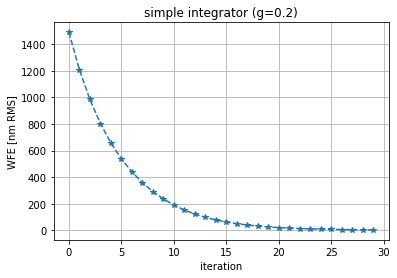

In [64]:
plt.plot(wfe_iter*1e9, '*--')
plt.grid()
plt.xlabel('iteration')
plt.title('simple integrator (g=%0.1f)'%gain)
plt.ylabel('WFE [nm RMS]')

Global piston [nm]: -858.2
Segment piston [nm]: [-859.1 -862.3 -858.  -859.5 -856.  -853.5 -859. ]


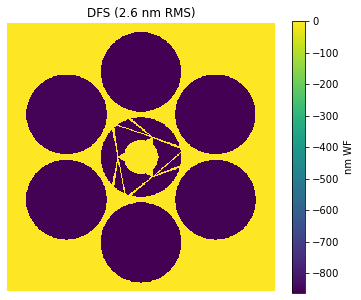

In [65]:
wfpt.show_wavefront(path='DFS')
print("Global piston [nm]: %0.1f"%(wfpt.dfs_src.piston('pupil')*1e9))
print("Segment piston [nm]: "+np.array_str(wfpt.dfs_src.piston('segments')*1e9,
                                          precision=1))

## Rec Test 4. M1 PTT - SH+DFS
Merged reconstructor controlling segment piston *and* segment tip-tilt.

In [25]:
D['M1'].keys()

dict_keys(['sh-dm', 'sh-stt', 'dfs-dm', 'dfs-stt', 'dfs-spp'])

### Interaction Matrices

In [68]:
#-- M1 PTT - DFS
D_PTT_DFS = DFSsig2pist @ np.concatenate([D['M1']['dfs-spp'], D['M1']['dfs-stt']], axis=1)

#-- M1 PTT - SH
D_PTT_SH = np.concatenate([np.zeros((wfpt.shs.get_measurement_size(),7)), D['M1']['sh-stt']], axis=1)

### Merged Interaction Matrix

In [69]:
dfs_norm = np.linalg.norm(D_PTT_DFS)
sh_norm = np.linalg.norm(D_PTT_SH)
D_PTT = np.concatenate((D_PTT_DFS/dfs_norm, D_PTT_SH/sh_norm), axis=0)

### SVD analysis

M1 PTT - DFS IM:
(2472, 21)
conditioning number:
667907.0951645309


Text(0.5, 1.0, 'M1 PTT - SH+DFS (on-axis)')

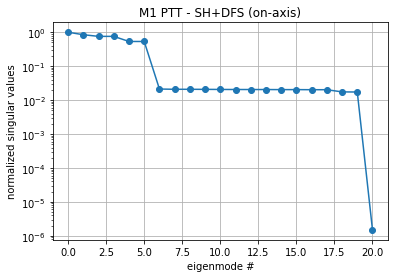

In [70]:
print('M1 PTT - DFS IM:')
print(D_PTT.shape)
print("conditioning number:")
print(np.linalg.cond(D_PTT))

UU1, ss1, VVT1 = np.linalg.svd(D_PTT, full_matrices=False)
plt.semilogy(ss1/np.max(ss1), 'o-')
plt.grid()
plt.ylabel('normalized singular values')
plt.xlabel('eigenmode #')
plt.title('M1 PTT - SH+DFS (on-axis)')

#### Show the shape of a particular eigenmode just for fun

Text(0.5, 1.0, 'eigenmode #21')

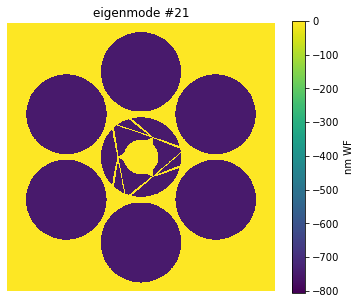

In [71]:
this_eigen = 20
eigenmodevec = np.copy(VVT1[this_eigen,:]) * 1e-6

wfpt.reset()
state = wfpt.state
state['M1_PTT']['segment piston'][:] = eigenmodevec[0:7]
state['M1_PTT']['segment tip-tilt'][:] = eigenmodevec[7:].reshape((7,2))

wfpt.update(state)
wfpt.shs_path.propagate(wfpt.shs_src)

fig, ax1 = plt.subplots()
fig.set_size_inches((6,5))
wfpt.show_wavefront(path='SH', fig=fig, ax=ax1)
ax1.set_title('eigenmode #%d'%(this_eigen+1))

### Merged reconstructor

In [72]:
Wp = np.zeros((21,21))
Wp[0:7,0:7] = 1e15*np.ones((7,7))
R_PTT = np.linalg.solve(D_PTT.T@D_PTT+Wp,D_PTT.T)

### Test reconstructor

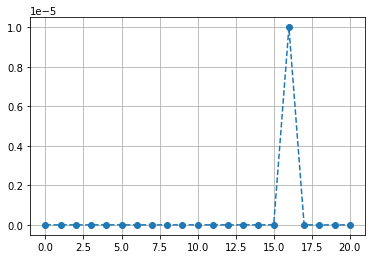

In [73]:
wfpt.reset()

state = wfpt.state
#state['M1_PTT']['segment piston'][0] = 100e-9
state['M1_PTT']['segment tip-tilt'][4,1] = 1e-5
wfpt.update(state)
wfpt.propagate()

wfpt.shs.process()
shs_meas = wfpt.shs.get_measurement()

wfpt.dfs.fft()
wfpt.dfs.process()
dfs_meas = DFSsig2pist @ wfpt.dfs.get_measurement()

PZmeas = np.concatenate((dfs_meas/dfs_norm, shs_meas/sh_norm))

ptt_comm = R_PTT @ PZmeas

#plt.imshow(WFin-opd0, origin='lower', interpolation='None')
#plt.colorbar()
plt.plot(ptt_comm, 'o--')
plt.grid()

### Perform a closed-loop test

#### Introduce a scramble

In [74]:
from numpy.random import default_rng
rng = default_rng(seed=1454)

Global piston [nm]: -843.1
Segment piston [nm]: [-1517.3 -3236.5  -724.2 -1486.2   504.3  1689.7 -1246. ]


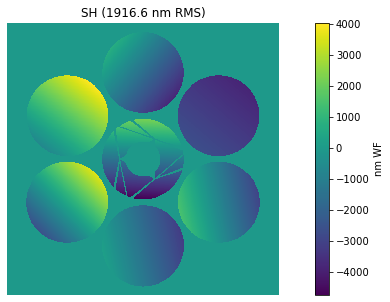

In [75]:
# Scramble:
wfpt.reset()
state0 = wfpt.state
state0['M1_PTT']['segment piston'][:] = rng.standard_normal(size=7) * 1e-6
state0['M1_PTT']['segment tip-tilt'][:] = rng.standard_normal(size=(7,2)) * 1e-4
#state0['M1_DM']['actuators'][181] = 0.5
#state0['M1_DM']['actuators'][:] = rng.standard_normal(size=wfpt.shs_path.M1_DM.modes.n_mode)*0.05
wfpt.update(state0)

# Visualize the scramble
wfpt.shs_src.reset()
wfpt.shs_path.propagate(wfpt.shs_src)

fig, ax1 = plt.subplots()
fig.set_size_inches((13,5))
wfpt.show_wavefront(path='SH', fig=fig, ax=ax1)
print("Global piston [nm]: %0.1f"%(wfpt.shs_src.piston('pupil')*1e9))
print("Segment piston [nm]: "+np.array_str(wfpt.shs_src.piston('segments')*1e9,
                                          precision=1))

#### Close the loop

In [76]:
totSimulIter = 30
gain = 0.5
tid = StopWatch()

M1_PTT_comm_buffer = np.zeros(21)
wfe_iter = np.zeros(totSimulIter)

In [77]:
# Get 
wfpt.reset()
state = wfpt.state

# Load initial scramble
wfpt.update(state0)

for jj in range(totSimulIter):
    tid.tic()
    wfpt.reset_sources()
    wfpt.reset_sensors()
    wfpt.propagate()
    wfe_iter[jj] = wfpt.shs_src.phaseRms()
    
    #--- WFS measurements and command
    wfpt.shs.process()
    shs_meas = wfpt.shs.get_measurement()

    wfpt.dfs.fft()
    wfpt.dfs.process()
    dfs_meas = DFSsig2pist @ wfpt.dfs.get_measurement()

    PZmeas = np.concatenate((dfs_meas/dfs_norm, shs_meas/sh_norm))
    M1_PTT_delta_comm = R_PTT @ PZmeas
    M1_PTT_comm_buffer += gain * M1_PTT_delta_comm
    
    #--- Update state vector
    state['M1_PTT']['segment piston'][:] = -M1_PTT_comm_buffer[0:7]
    state['M1_PTT']['segment tip-tilt'][:] = -M1_PTT_comm_buffer[7:].reshape((7,2))
    wfpt.update(state0+state)

    tid.toc()
    sys.stdout.write("\r iter: %d/%d, ET: %.2f, WFE [nm WF RMS] on-axis: %0.1f"%(jj, totSimulIter, tid.elapsedTime, wfe_iter[jj]*1e9))
    sys.stdout.flush()   


 iter: 29/30, ET: 1677.67, WFE [nm WF RMS] on-axis: 0.206

Text(0, 0.5, 'WFE [nm RMS]')

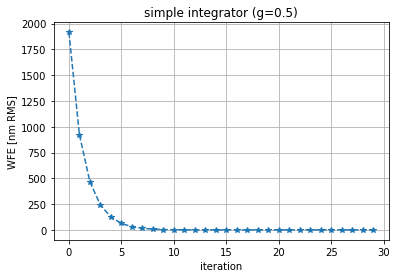

In [78]:
plt.plot(wfe_iter*1e9, '*--')
plt.grid()
plt.xlabel('iteration')
plt.title('simple integrator (g=%0.1f)'%gain)
plt.ylabel('WFE [nm RMS]')

Global piston [nm]: -858.2
Segment piston [nm]: [-858.2 -858.2 -858.2 -858.2 -858.2 -858.2 -858.2]


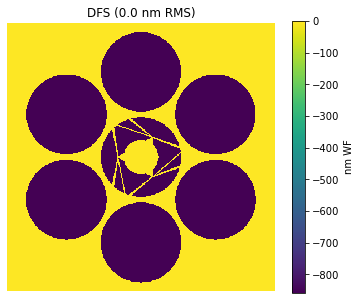

In [79]:
wfpt.show_wavefront(path='DFS')
print("Global piston [nm]: %0.1f"%(wfpt.dfs_src.piston('pupil')*1e9))
print("Segment piston [nm]: "+np.array_str(wfpt.dfs_src.piston('segments')*1e9, precision=1))

## Rec Test 4. M1 PTT+DM - SH+DFS
Merged reconstructor controlling segment piston, segment tip-tilt, and DM actuators.

In [80]:
D['M1'].keys()

dict_keys(['sh-dm', 'sh-stt', 'dfs-dm', 'dfs-stt', 'dfs-spp'])

### Interaction Matrices

In [82]:
#-- M1 PTT - DFS
D_PTT_DFS = DFSsig2pist @ np.concatenate([D['M1']['dfs-spp'], D['M1']['dfs-stt']], axis=1)

#-- M1 PTT - SH
D_PTT_SH = np.concatenate([np.zeros((wfpt.shs.get_measurement_size(),7)), D['M1']['sh-stt']], axis=1)

#-- M1 DM - SH
D_DM_SH = D['M1']['sh-dm']

#-- M1 DM - DFS
D_DM_DFS = DFSsig2pist @ D['M1']['dfs-dm']

In [86]:
D_DFS = np.concatenate([D_PTT_DFS, D_DM_DFS], axis=1)
D_SH = np.concatenate([D_PTT_SH, D_DM_SH], axis=1)

In [87]:
np.linalg.norm(D_PTT_DFS), np.linalg.norm(D_PTT_SH), np.linalg.norm(D_DM_SH), np.linalg.norm(D_DM_DFS)

(4.899147305015881,
 0.19799345068310323,
 0.00021050295093795777,
 1.3370568417761525e-06)

In [88]:
np.linalg.norm(D_DFS), np.linalg.norm(D_SH)

(4.899147305016063, 0.19799356258448084)

### Merged Interaction Matrix

In [90]:
dfs_norm = np.linalg.norm(D_DFS)
sh_norm = np.linalg.norm(D_SH)
D_M1 = np.concatenate((D_DFS/dfs_norm, D_SH/sh_norm), axis=0)
ndof = 21+292

### SVD analysis

M1 PTT - DFS IM:
(2472, 313)
conditioning number:
2052794.0588566246


Text(0.5, 1.0, 'M1 PTT+DM - SH+DFS (on-axis)')

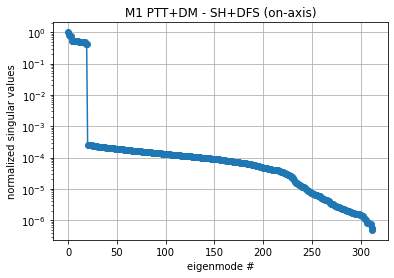

In [91]:
print('M1 PTT - DFS IM:')
print(D_M1.shape)
print("conditioning number:")
print(np.linalg.cond(D_M1))

UU1, ss1, VVT1 = np.linalg.svd(D_M1, full_matrices=False)
plt.semilogy(ss1/np.max(ss1), 'o-')
plt.grid()
plt.ylabel('normalized singular values')
plt.xlabel('eigenmode #')
plt.title('M1 PTT+DM - SH+DFS (on-axis)')

#### Show the shape of a particular eigenmode just for fun

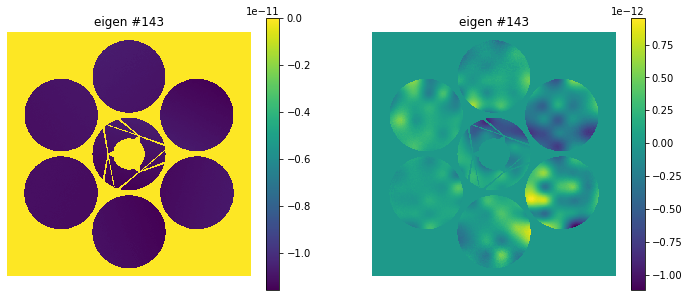

In [112]:
this_eigen = 142
eigenmodevec = np.copy(VVT1[this_eigen,:]) * 1e-6

wfpt.reset()
state = wfpt.state
state['M1_PTT']['segment piston'][:] = eigenmodevec[0:7]
state['M1_PTT']['segment tip-tilt'][:] = eigenmodevec[7:21].reshape((7,2))
wfpt.update(state)
wfpt.shs_path.propagate(wfpt.shs_src)
opdptt = wfpt.opd()

wfpt.reset()
state = wfpt.state
state['M1_DM']['actuators'][:] = eigenmodevec[21:]
wfpt.update(state)
wfpt.shs_path.propagate(wfpt.shs_src)
opddm = wfpt.opd()

fig, (ax1,ax2) = plt.subplots(ncols=2)
fig.set_size_inches((12,5))
wfpt_visulib.show_wavefront(opdptt, fig=fig, ax=ax1, title='eigen #%d'%(this_eigen+1))
wfpt_visulib.show_wavefront(opddm,  fig=fig, ax=ax2, title='eigen #%d'%(this_eigen+1))


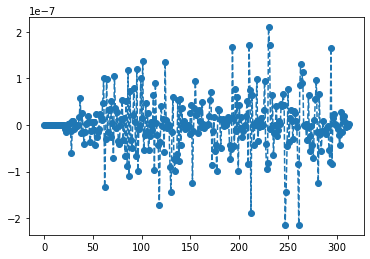

In [113]:

plt.plot(eigenmodevec, 'o--')

### Merged reconstructor

In [92]:
Wp = np.zeros((ndof,ndof))
Wp[0:7,0:7] = 1e15*np.ones((7,7))
R_M1 = np.linalg.solve(D_M1.T@D_M1+Wp,D_M1.T)

### Test reconstructor

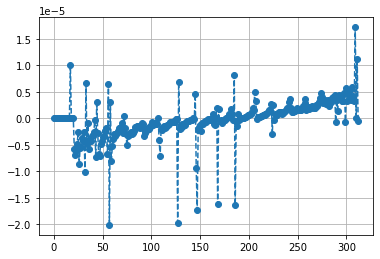

In [114]:
wfpt.reset()

state = wfpt.state
#state['M1_PTT']['segment piston'][0] = 100e-9
state['M1_PTT']['segment tip-tilt'][5,0] = 1e-5
wfpt.update(state)
wfpt.propagate()

wfpt.shs.process()
shs_meas = wfpt.shs.get_measurement()

wfpt.dfs.fft()
wfpt.dfs.process()
dfs_meas = DFSsig2pist @ wfpt.dfs.get_measurement()

PZmeas = np.concatenate((dfs_meas/dfs_norm, shs_meas/sh_norm))

m1_comm = R_M1 @ PZmeas

#plt.imshow(WFin-opd0, origin='lower', interpolation='None')
#plt.colorbar()
plt.plot(m1_comm, 'o--')
plt.grid()

### Perform a closed-loop test

#### Introduce a scramble

In [115]:
from numpy.random import default_rng
rng = default_rng(seed=1454)

Global piston [nm]: -712.9
Segment piston [nm]: [-1204.1 -3331.1  -805.2 -1204.1   946.9  1717.4 -1269.3]


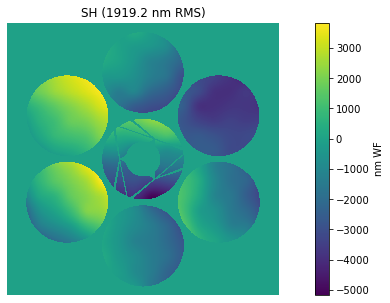

In [116]:
# Scramble:
wfpt.reset()
state0 = wfpt.state
state0['M1_PTT']['segment piston'][:] = rng.standard_normal(size=7) * 1e-6
state0['M1_PTT']['segment tip-tilt'][:] = rng.standard_normal(size=(7,2)) * 1e-4
state0['M1_DM']['actuators'][:] = rng.standard_normal(size=wfpt.shs_path.M1_DM.modes.n_mode)*0.05
wfpt.update(state0)

# Visualize the scramble
wfpt.shs_src.reset()
wfpt.shs_path.propagate(wfpt.shs_src)

fig, ax1 = plt.subplots()
fig.set_size_inches((13,5))
wfpt.show_wavefront(path='SH', fig=fig, ax=ax1)
print("Global piston [nm]: %0.1f"%(wfpt.shs_src.piston('pupil')*1e9))
print("Segment piston [nm]: "+np.array_str(wfpt.shs_src.piston('segments')*1e9,
                                          precision=1))

#### Close the loop

In [121]:
totSimulIter = 30
gain = 0.5
tid = StopWatch()

M1_comm_buffer = np.zeros(ndof)
wfe_iter = np.zeros(totSimulIter)

In [122]:
# Get 
wfpt.reset()
state = wfpt.state

# Load initial scramble
wfpt.update(state0)

for jj in range(totSimulIter):
    tid.tic()
    wfpt.reset_sources()
    wfpt.reset_sensors()
    wfpt.propagate()
    wfe_iter[jj] = wfpt.shs_src.phaseRms()
    
    #--- WFS measurements and command
    wfpt.shs.process()
    shs_meas = wfpt.shs.get_measurement()

    wfpt.dfs.fft()
    wfpt.dfs.process()
    dfs_meas = DFSsig2pist @ wfpt.dfs.get_measurement()

    PZmeas = np.concatenate((dfs_meas/dfs_norm, shs_meas/sh_norm))
    M1_delta_comm = R_M1 @ PZmeas
    M1_comm_buffer += gain * M1_delta_comm
    
    #--- Update state vector
    state['M1_PTT']['segment piston'][:] = -M1_comm_buffer[0:7]
    state['M1_PTT']['segment tip-tilt'][:] = -M1_comm_buffer[7:21].reshape((7,2))
    state['M1_DM']['actuators'][:] = -M1_comm_buffer[21:]
    wfpt.update(state0+state)

    tid.toc()
    sys.stdout.write("\r iter: %d/%d, ET: %.2f, WFE [nm WF RMS] on-axis: %0.1f"%(jj, totSimulIter, tid.elapsedTime, wfe_iter[jj]*1e9))
    sys.stdout.flush()   


 iter: 29/30, ET: 1664.78, WFE [nm WF RMS] on-axis: 1.161

Text(0, 0.5, 'WFE [nm RMS]')

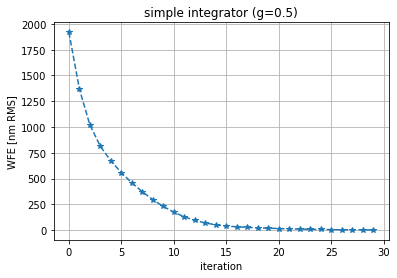

In [123]:
plt.plot(wfe_iter*1e9, '*--')
plt.grid()
plt.xlabel('iteration')
plt.title('simple integrator (g=%0.1f)'%gain)
plt.ylabel('WFE [nm RMS]')

Global piston [nm]: -858.2
Segment piston [nm]: [-858.2 -859.5 -859.8 -857.8 -856.6 -857.2 -858.4]


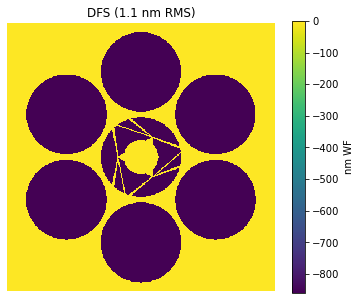

In [124]:
wfpt.show_wavefront(path='DFS')
print("Global piston [nm]: %0.1f"%(wfpt.dfs_src.piston('pupil')*1e9))
print("Segment piston [nm]: "+np.array_str(wfpt.dfs_src.piston('segments')*1e9, precision=1))